# Simulation of ARCS powder experiment for Aluminum

In [ ]:
# some goodies
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np, histogram.hdf as hh, histogram as H
import os

## Create workflow

workdir

In [ ]:
workdir = "/SNS/ARCS/IPTS-15398/shared/jiao-mcvine-sim/mcvine-aluminum"
!mkdir -p {workdir}
%cd {workdir}

In [ ]:
!mcvine workflow powder --instrument=ARCS --sample=V --workdir=mysim

In [ ]:
!ls mysim/

## Beam simulation

In [ ]:
# change to beam sim directory
%cd {workdir}/mysim/beam

In [ ]:
# show the simulation script
!cat run-beam.sh

** modify the simulation script (desired incident energy, neutron count) **

In [ ]:
%%time
%%script bash --out out_beam --err err_beam
mcvine instruments arcs beam -E=80 --ncount=1e9 --nodes=10

Check for errors

In [ ]:
# print out_beam
# print err_beam

After the beam simulation is done
* The main output are in the new folder "out".
* The ".h5" files are histograms of various sorts.
* The "neutron" file is the simulated neutrons of the beam incident on the sample

In [ ]:
!ls out

In [ ]:
# plot I(E) spectrum
ie = hh.load("out/ienergy.h5")
plt.plot(ie.energy, ie.I)

In [ ]:
# plot monitor 1 I(tof) spectrum
m1 = hh.load("out/mon1-itof-focused.h5")
plt.plot(m1.tof, m1.I)

How many neutron events at sample position were simulated?

In [ ]:
%%script bash
mcvine neutronstorage count out/neutrons

## Scattering simulation and reduction

The simulation directory contains a Makefile and various scripts to make it easy to run the simulation and analsysis.

In [ ]:
%cd {workdir}/mysim

In [ ]:
!ls

In [ ]:
# !cat scatter
# !cat create-nxs
# !cat reduce2iqe

### Change sample

In [ ]:
%cd {workdir}/mysim

#### Shape

In [ ]:
# cat sampleassembly/sampleassembly.xml

In [ ]:
%%file sampleassembly/sampleassembly.xml
<SampleAssembly name="Al-plate">

  <PowderSample name="Al" type="sample">
    <Shape>
      <block width="7*cm" height="10*cm" thickness="1*mm" />
    </Shape>
    <Phase type="crystal">
      <ChemicalFormula>Al</ChemicalFormula>
      <xyzfile>Al.xyz</xyzfile>
    </Phase>
  </PowderSample>

  <LocalGeometer registry-coordinate-system="InstrumentScientist">
    <Register name="Al" position="(0,0,0)" orientation="(0,0,0)"/>
  </LocalGeometer>

</SampleAssembly>

#### Crystal structure

In [ ]:
%%file sampleassembly/Al.xyz
1
0 2.024660 2.024660  2.024660 0 2.024660 2.024660  2.024660  0
Al 0  0  0

In [ ]:
# cat sampleassembly/Al.xyz

In [ ]:
from mcvine import resources

In [ ]:
Al_300K = os.path.abspath(os.path.join(resources.sample('Al', temperature='300K'), '..'))

In [ ]:
cp {os.path.join(Al_300K, 'powderdiffr', 'Al.laz')} ./sampleassembly/

#### Phonon data

In [ ]:
cp -a {os.path.join(Al_300K, 'phonons')} sampleassembly/Al-phonons

#### Scattering kernels

Compute the DW core needed by some kernels

In [ ]:
!mcvine-debye-waller-core-from-phonon-dos -m=27. -T=300 -dos=sampleassembly/Al-phonons/DOS

Kernel specifications

In [ ]:
%%file sampleassembly/Al-scatterer.xml
<?xml version="1.0"?>

<!DOCTYPE scatterer>

<!-- mcweights: monte-carlo weights for 3 possible processes:
     absorption, scattering, transmission -->
<homogeneous_scatterer 
  mcweights="0, 9, 1"
  max_multiplescattering_loops="4"
  >

  <KernelContainer>

    <!-- coherent -->
    <KernelContainer average="yes">
      
      <SimplePowderDiffractionKernel Dd_over_d="1e-5" DebyeWaller_factor="0" laz-path="Al.laz">
      </SimplePowderDiffractionKernel>
      
      <Phonon_CoherentInelastic_PolyXtal_Kernel max-omega='40*meV'>
        <LinearlyInterpolatedDispersion idf-data-path="Al-phonons"/>
      </Phonon_CoherentInelastic_PolyXtal_Kernel>

      <MultiPhonon_Kernel Qmax="30/angstrom">
        <LinearlyInterpolatedDOS idf-data-path="Al-phonons/DOS"/>
      </MultiPhonon_Kernel>
      
    </KernelContainer>

    <!-- incoherent -->
    <KernelContainer average="yes">

      <Phonon_IncoherentElastic_Kernel dw_core='0.0115394036564*angstrom**2'>
      </Phonon_IncoherentElastic_Kernel>

      <Phonon_IncoherentInelastic_Kernel>
        <LinearlyInterpolatedDOS idf-data-path="Al-phonons/DOS">
        </LinearlyInterpolatedDOS>
      </Phonon_IncoherentInelastic_Kernel>

    </KernelContainer>

  </KernelContainer>
  
</homogeneous_scatterer>

#### Final check

In [ ]:
ls sampleassembly/

In [ ]:
# !cat sampleassembly/sampleassembly.xml
# !cat sampleassembly/NonRadGraphite-scatterer.xml

### Update det sim script

### Update reduction script

### Run sim

In [ ]:
!make clean

~18minutes

In [ ]:
%%time
%%script bash 
make NCOUNT=2e7 BUFFER_SIZE=1000000 NODES=20 QAXIS="0 15 0.1"

In [ ]:
#! cat log.scatter
#! cat log.create-nxs
#! cat log.reduce

In [ ]:
# H.plot(hh.load('./mp-sqe-0.h5'))

plot z in (0, 3e-07)


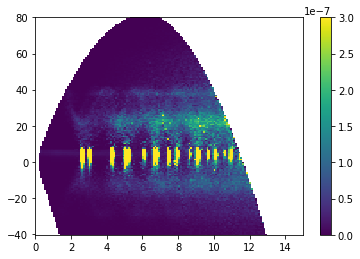

In [5]:
iqe = hh.load("iqe.h5").transpose()
H.plot(iqe, min=0, max=3e-7)